In [2]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import numpy as np
import torch
import plons

from matplotlib.lines import Line2D
from astropy          import constants, units

from pomme.model import TensorModel, SphericallySymmetric
from pomme.loss  import Loss
from pomme.haar  import Haar

# Truth
---

In [3]:
setupData = plons.LoadSetup('/STER/frederikd/', "wind")
dumpData  = plons.LoadFullDump('/STER/frederikd/wind_00600', setupData)

position = dumpData["position"]*1e-2     # position vectors        [cm   -> m]
velocity = dumpData["velocity"]*1e3      # velocity vectors        [km/s -> m/s]
rho      = dumpData["rho"]               # density                 [g/cm^3]
tmp      = dumpData["Tgas"]              # temperature             [K]
tmp[tmp<2.725] = 2.725                   # Cut-off temperatures below 2.725 K

v_x, v_y, v_z = velocity[:,0], velocity[:,1], velocity[:,2]

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=10)

imin = 2**(haar.q-3)
imax = 3*imin

# g    -> kg    *1.0e-3
# cm-3 -> m^-3  *1.0e+6

rho = rho * 1.0e-3 * 1.0e+6

rho_dat = haar.map_data(rho, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

In [4]:
rho_dat.shape

(256, 256, 256)

In [5]:
haar = Haar(position, q=8)

imin = 2**(haar.q-3)
imax = 3*imin

rho_ref = haar.map_data(rho, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_ref = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_ref = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_ref = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_ref = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

v_r_ref = np.sqrt(v_x_ref**2 + v_y_ref**2 + v_z_ref**2)

In [6]:
rho_ref.shape

(64, 64, 64)

In [7]:
model_test = TensorModel(shape=rho_dat.shape, sizes=haar.xyz_L)

rs  = model_test.get_radius(origin='centre')
rs /= (1.0 * units.au).si.value

v_r = np.sqrt(v_x_dat**2 + v_y_dat**2 + v_z_dat**2)

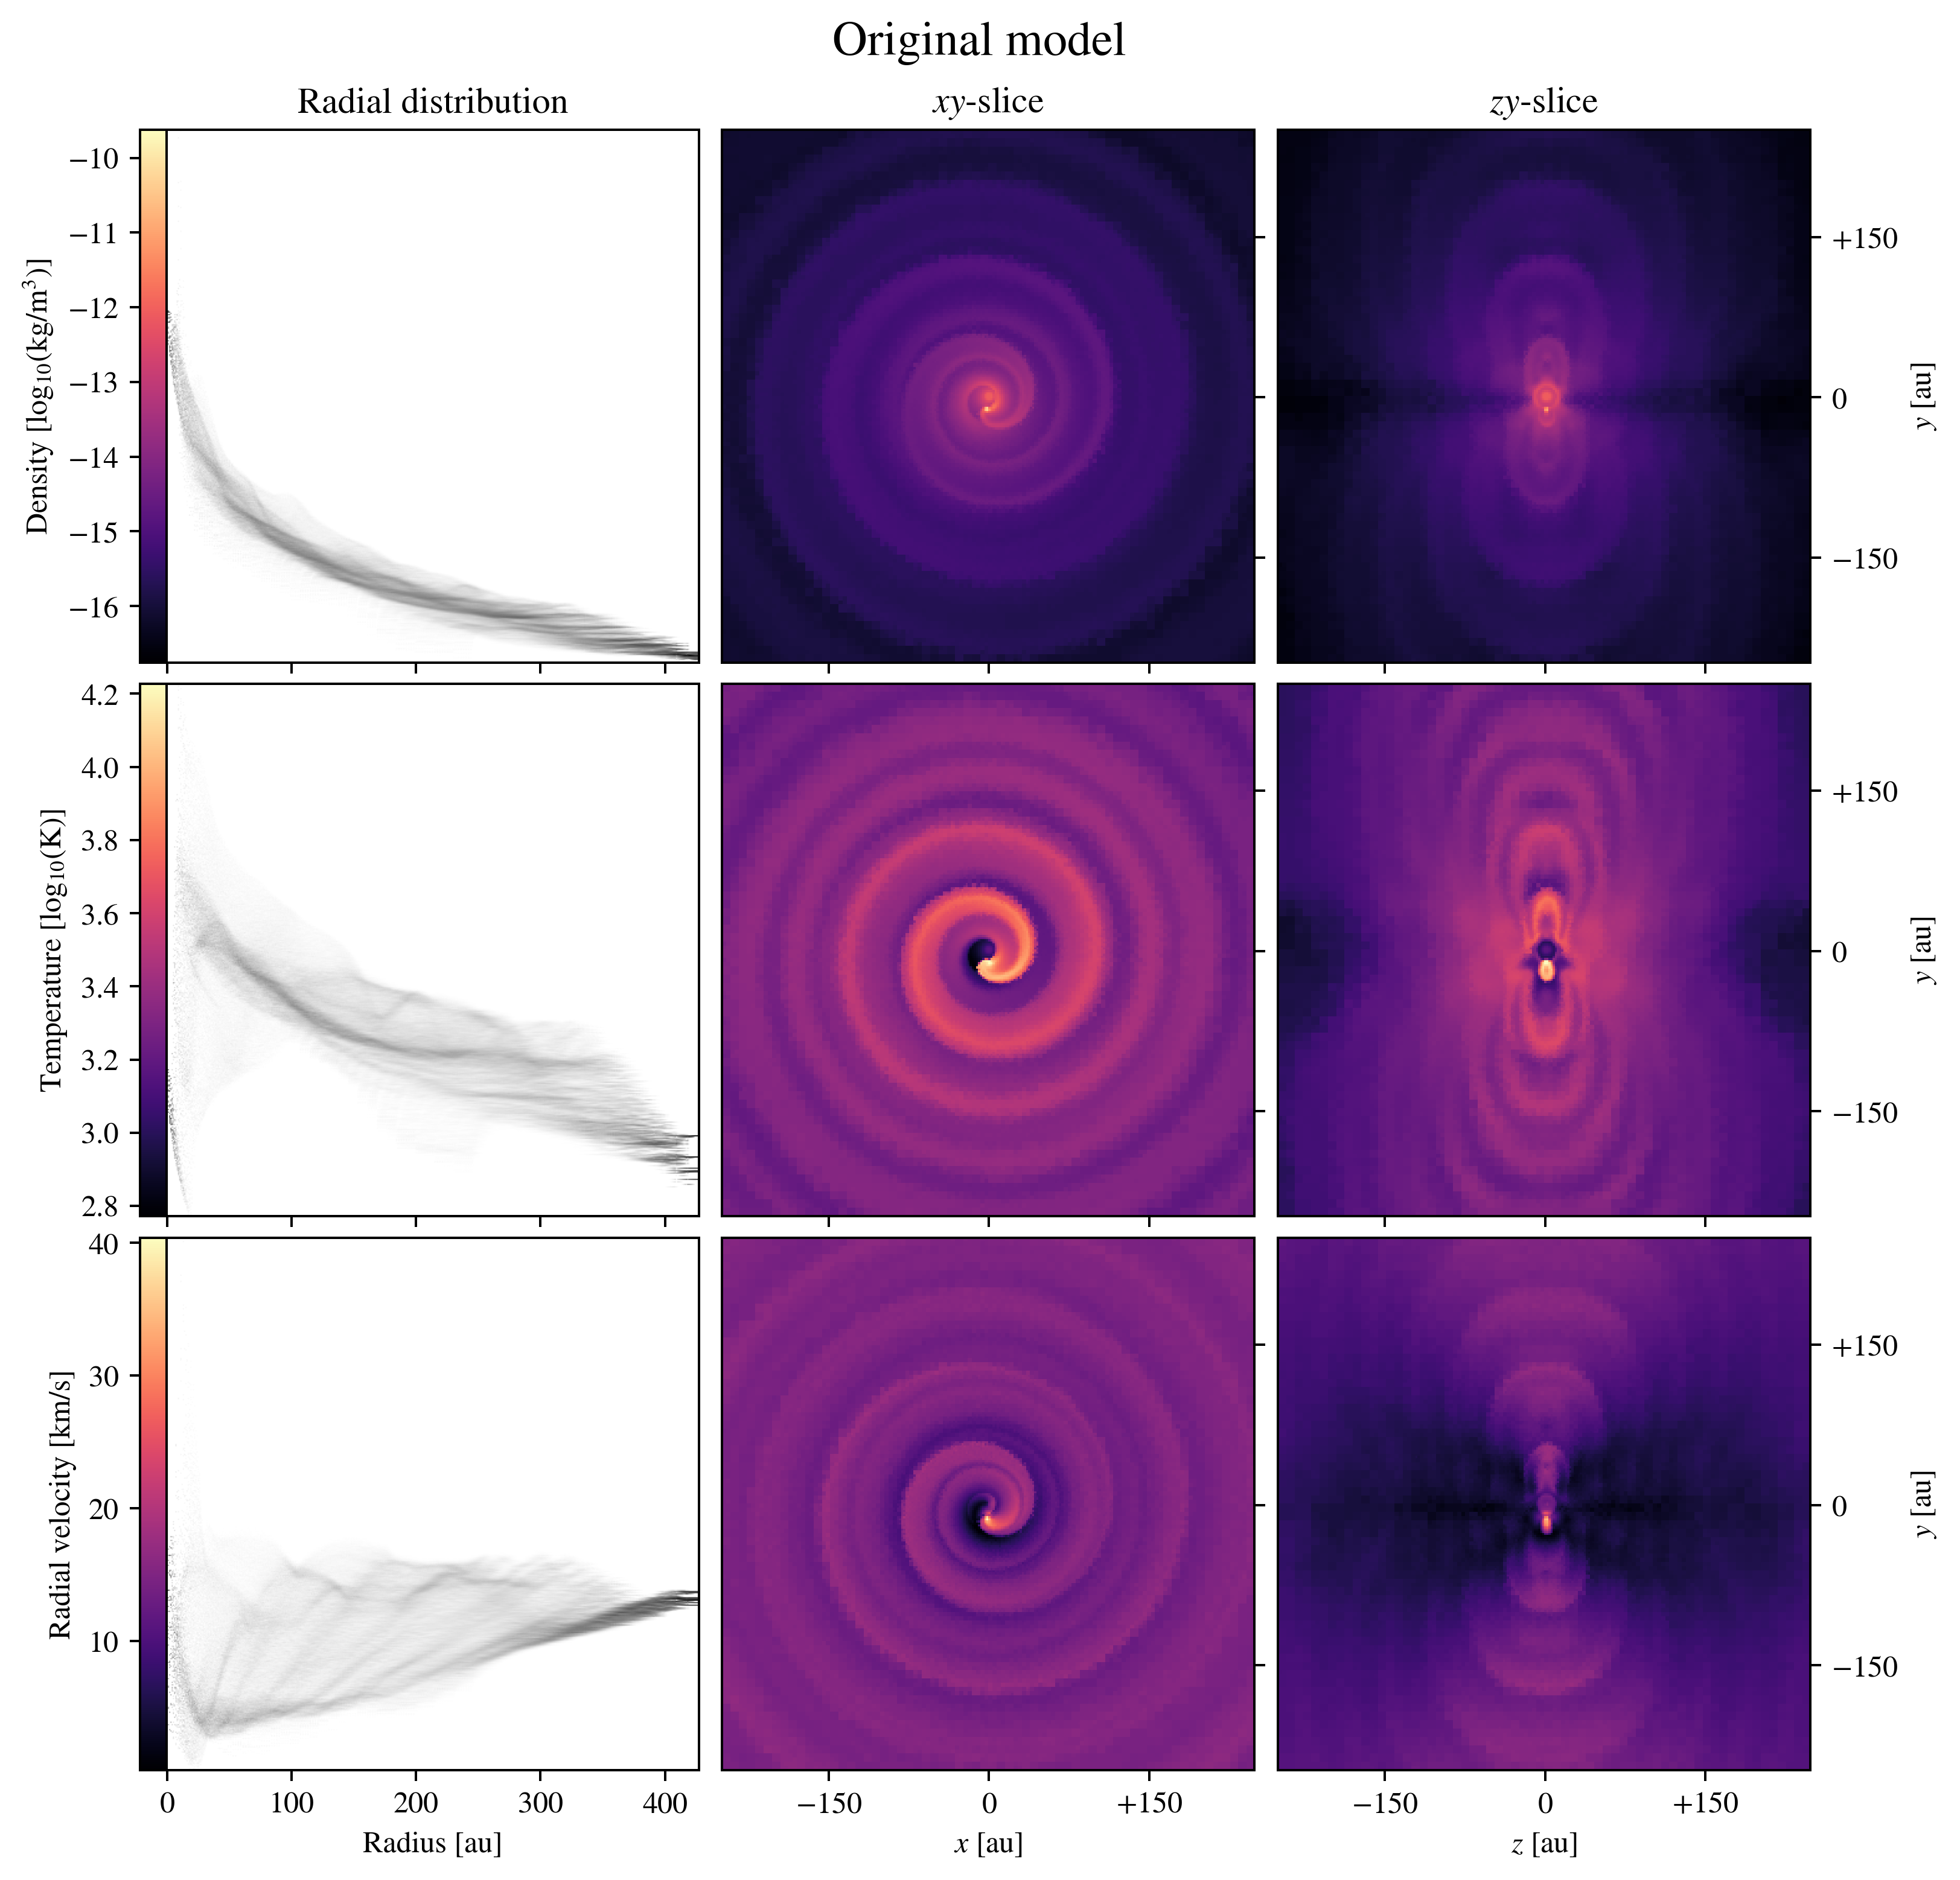

In [8]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

fig.suptitle('Original model', fontsize=16, x=0.527, y=0.93)

cmap = 'magma' #cubehelix'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(rho_dat)
rho_min = data.min()
rho_max = data.max()

num, rho_x_edges, rho_y_edges = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[0,1].imshow(data[:,  :,128].T, vmin=rho_min, vmax=rho_max, cmap=cmap)
pp = axs[0,2].imshow(data[128, :, :]  , vmin=rho_min, vmax=rho_max, cmap=cmap)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([51, 128, 205], [])
axs[0,1].set_yticks([51, 128, 205], [])
axs[0,2].set_xticks([51, 128, 205], [])
axs[0,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='Density [log$_{10}$(kg/m$^{3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_dat)
tmp_min = data.min()
tmp_max = data.max()

num, tmp_x_edges, tmp_y_edges = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[1,1].imshow(data[:,  :,128].T, vmin=tmp_min, vmax=tmp_max, cmap=cmap)
pp = axs[1,2].imshow(data[128, :, :]  , vmin=tmp_min, vmax=tmp_max, cmap=cmap)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([51, 128, 205], [])
axs[1,1].set_yticks([51, 128, 205], [])
axs[1,2].set_xticks([51, 128, 205], [])
axs[1,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()


data = v_r / 1.0e+3
v_r_min = data.min()
v_r_max = data.max()

num, v_r_x_edges, v_r_y_edges = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[2,1].imshow(data[:,  :,128].T, vmin=v_r_min, vmax=v_r_max, cmap=cmap)
pp = axs[2,2].imshow(data[128, :, :]  , vmin=v_r_min, vmax=v_r_max, cmap=cmap)
# axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
axs[2,1].set_yticks([51, 128, 205], [])
axs[2,2].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
axs[2,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig('phantom_model_truth.png', dpi=360, bbox_inches='tight')

# Fit
---

In [16]:
name  = 'model_fit_it=600'
model = TensorModel.load(f'{name}.h5')
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +2.248e+01     +2.429e+01     +3.473e+01
  log_temperature            Free          True     +6.012e+00     +7.423e+00     +1.091e+01
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +5.134e+00     +9.193e+00     +1.021e+01
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [17]:
rho_fit = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit = torch.exp(model['log_temperature']).data.numpy()
v_r_fit = torch.exp(model['log_velocity_r' ]).data.numpy()

rs  = model.get_radius(origin='centre')
rs /= (1.0 * units.au).si.value

In [18]:
rho_fit.shape

(64, 64, 64)

In [19]:
256 / 64

4.0

/tmp/ipykernel_413865/3232184842.py:17: RuntimeWarning: invalid value encountered in true_divide
  axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_413865/3232184842.py:38: RuntimeWarning: invalid value encountered in true_divide
  axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_413865/3232184842.py:57: RuntimeWarning: invalid value encountered in true_divide
  axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')


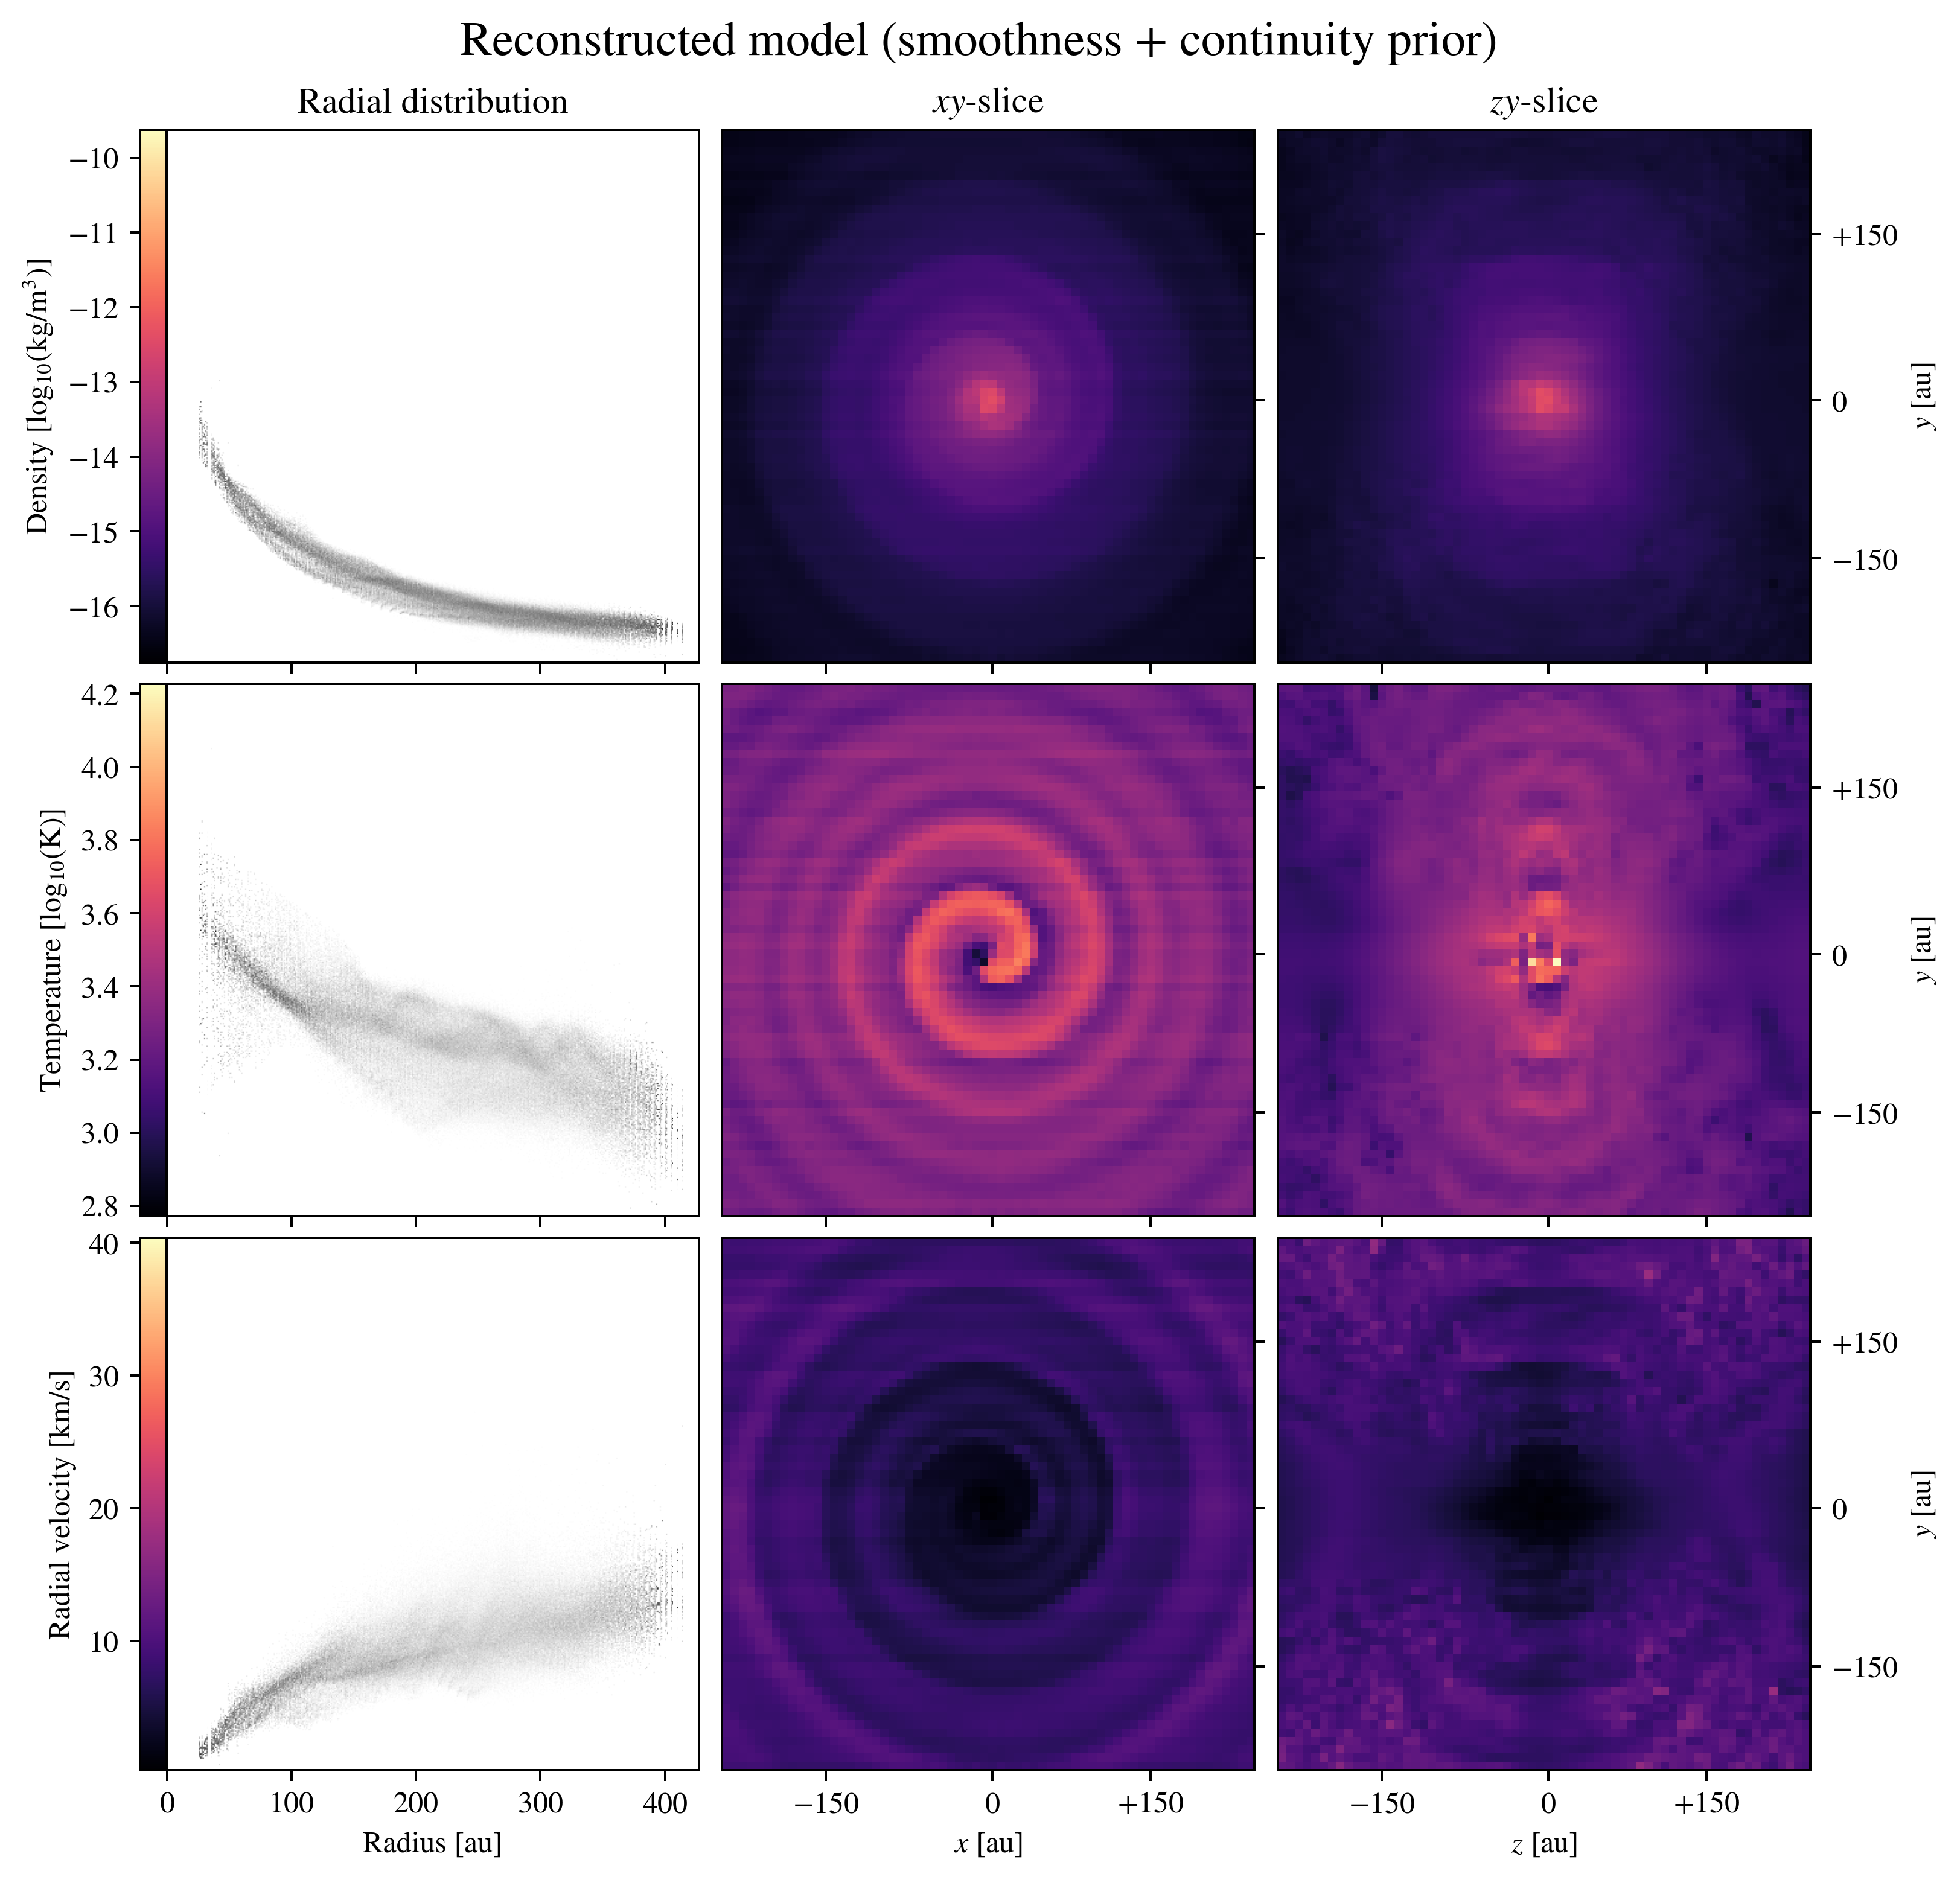

In [20]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

fig.suptitle('Reconstructed model (smoothness + continuity prior)', fontsize=16, x=0.527, y=0.93)

cmap = 'magma' #cubehelix'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(rho_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(rho_x_edges, rho_y_edges))[0]
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[0,1].imshow(data[:,  :,128//4].T, vmin=rho_min, vmax=rho_max, cmap=cmap)
pp = axs[0,2].imshow(data[128//4, :, :]  , vmin=rho_min, vmax=rho_max, cmap=cmap)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([51//4, 128//4, 205//4], [])
axs[0,1].set_yticks([51//4, 128//4, 205//4], [])
axs[0,2].set_xticks([51//4, 128//4, 205//4], [])
axs[0,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='Density [log$_{10}$(kg/m$^{3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(tmp_x_edges, tmp_y_edges))[0]
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[1,1].imshow(data[:,  :,128//4].T, vmin=tmp_min, vmax=tmp_max, cmap=cmap)
pp = axs[1,2].imshow(data[128//4, :, :]  , vmin=tmp_min, vmax=tmp_max, cmap=cmap)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([51//4, 128//4, 205//4], [])
axs[1,1].set_yticks([51//4, 128//4, 205//4], [])
axs[1,2].set_xticks([51//4, 128//4, 205//4], [])
axs[1,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()


data = v_r_fit / 1.0e+3
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(v_r_x_edges, v_r_y_edges))[0]
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[2,1].imshow(data[:,  :,128//4].T, vmin=v_r_min, vmax=v_r_max, cmap=cmap)
pp = axs[2,2].imshow(data[128//4, :, :]  , vmin=v_r_min, vmax=v_r_max, cmap=cmap)
# axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,1].set_yticks([51//4, 128//4, 205//4], [])
axs[2,2].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig(f'phantom_{name}.png', dpi=360, bbox_inches='tight')

# Fit no con
---

In [21]:
name  = 'model_fit_it_no_con=600'
model = TensorModel.load(f'{name}.h5')
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +2.298e+01     +2.438e+01     +3.310e+01
  log_temperature            Free          True     +5.496e+00     +7.463e+00     +1.008e+01
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +5.895e+00     +9.188e+00     +1.097e+01
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [22]:
rho_fit = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit = torch.exp(model['log_temperature']).data.numpy()
v_r_fit = torch.exp(model['log_velocity_r' ]).data.numpy()

rs  = model.get_radius(origin='centre')
rs /= (1.0 * units.au).si.value

In [23]:
rho_fit.shape

(64, 64, 64)

In [24]:
256 / 64

4.0

/tmp/ipykernel_413865/1896414070.py:17: RuntimeWarning: invalid value encountered in true_divide
  axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_413865/1896414070.py:38: RuntimeWarning: invalid value encountered in true_divide
  axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_413865/1896414070.py:57: RuntimeWarning: invalid value encountered in true_divide
  axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')


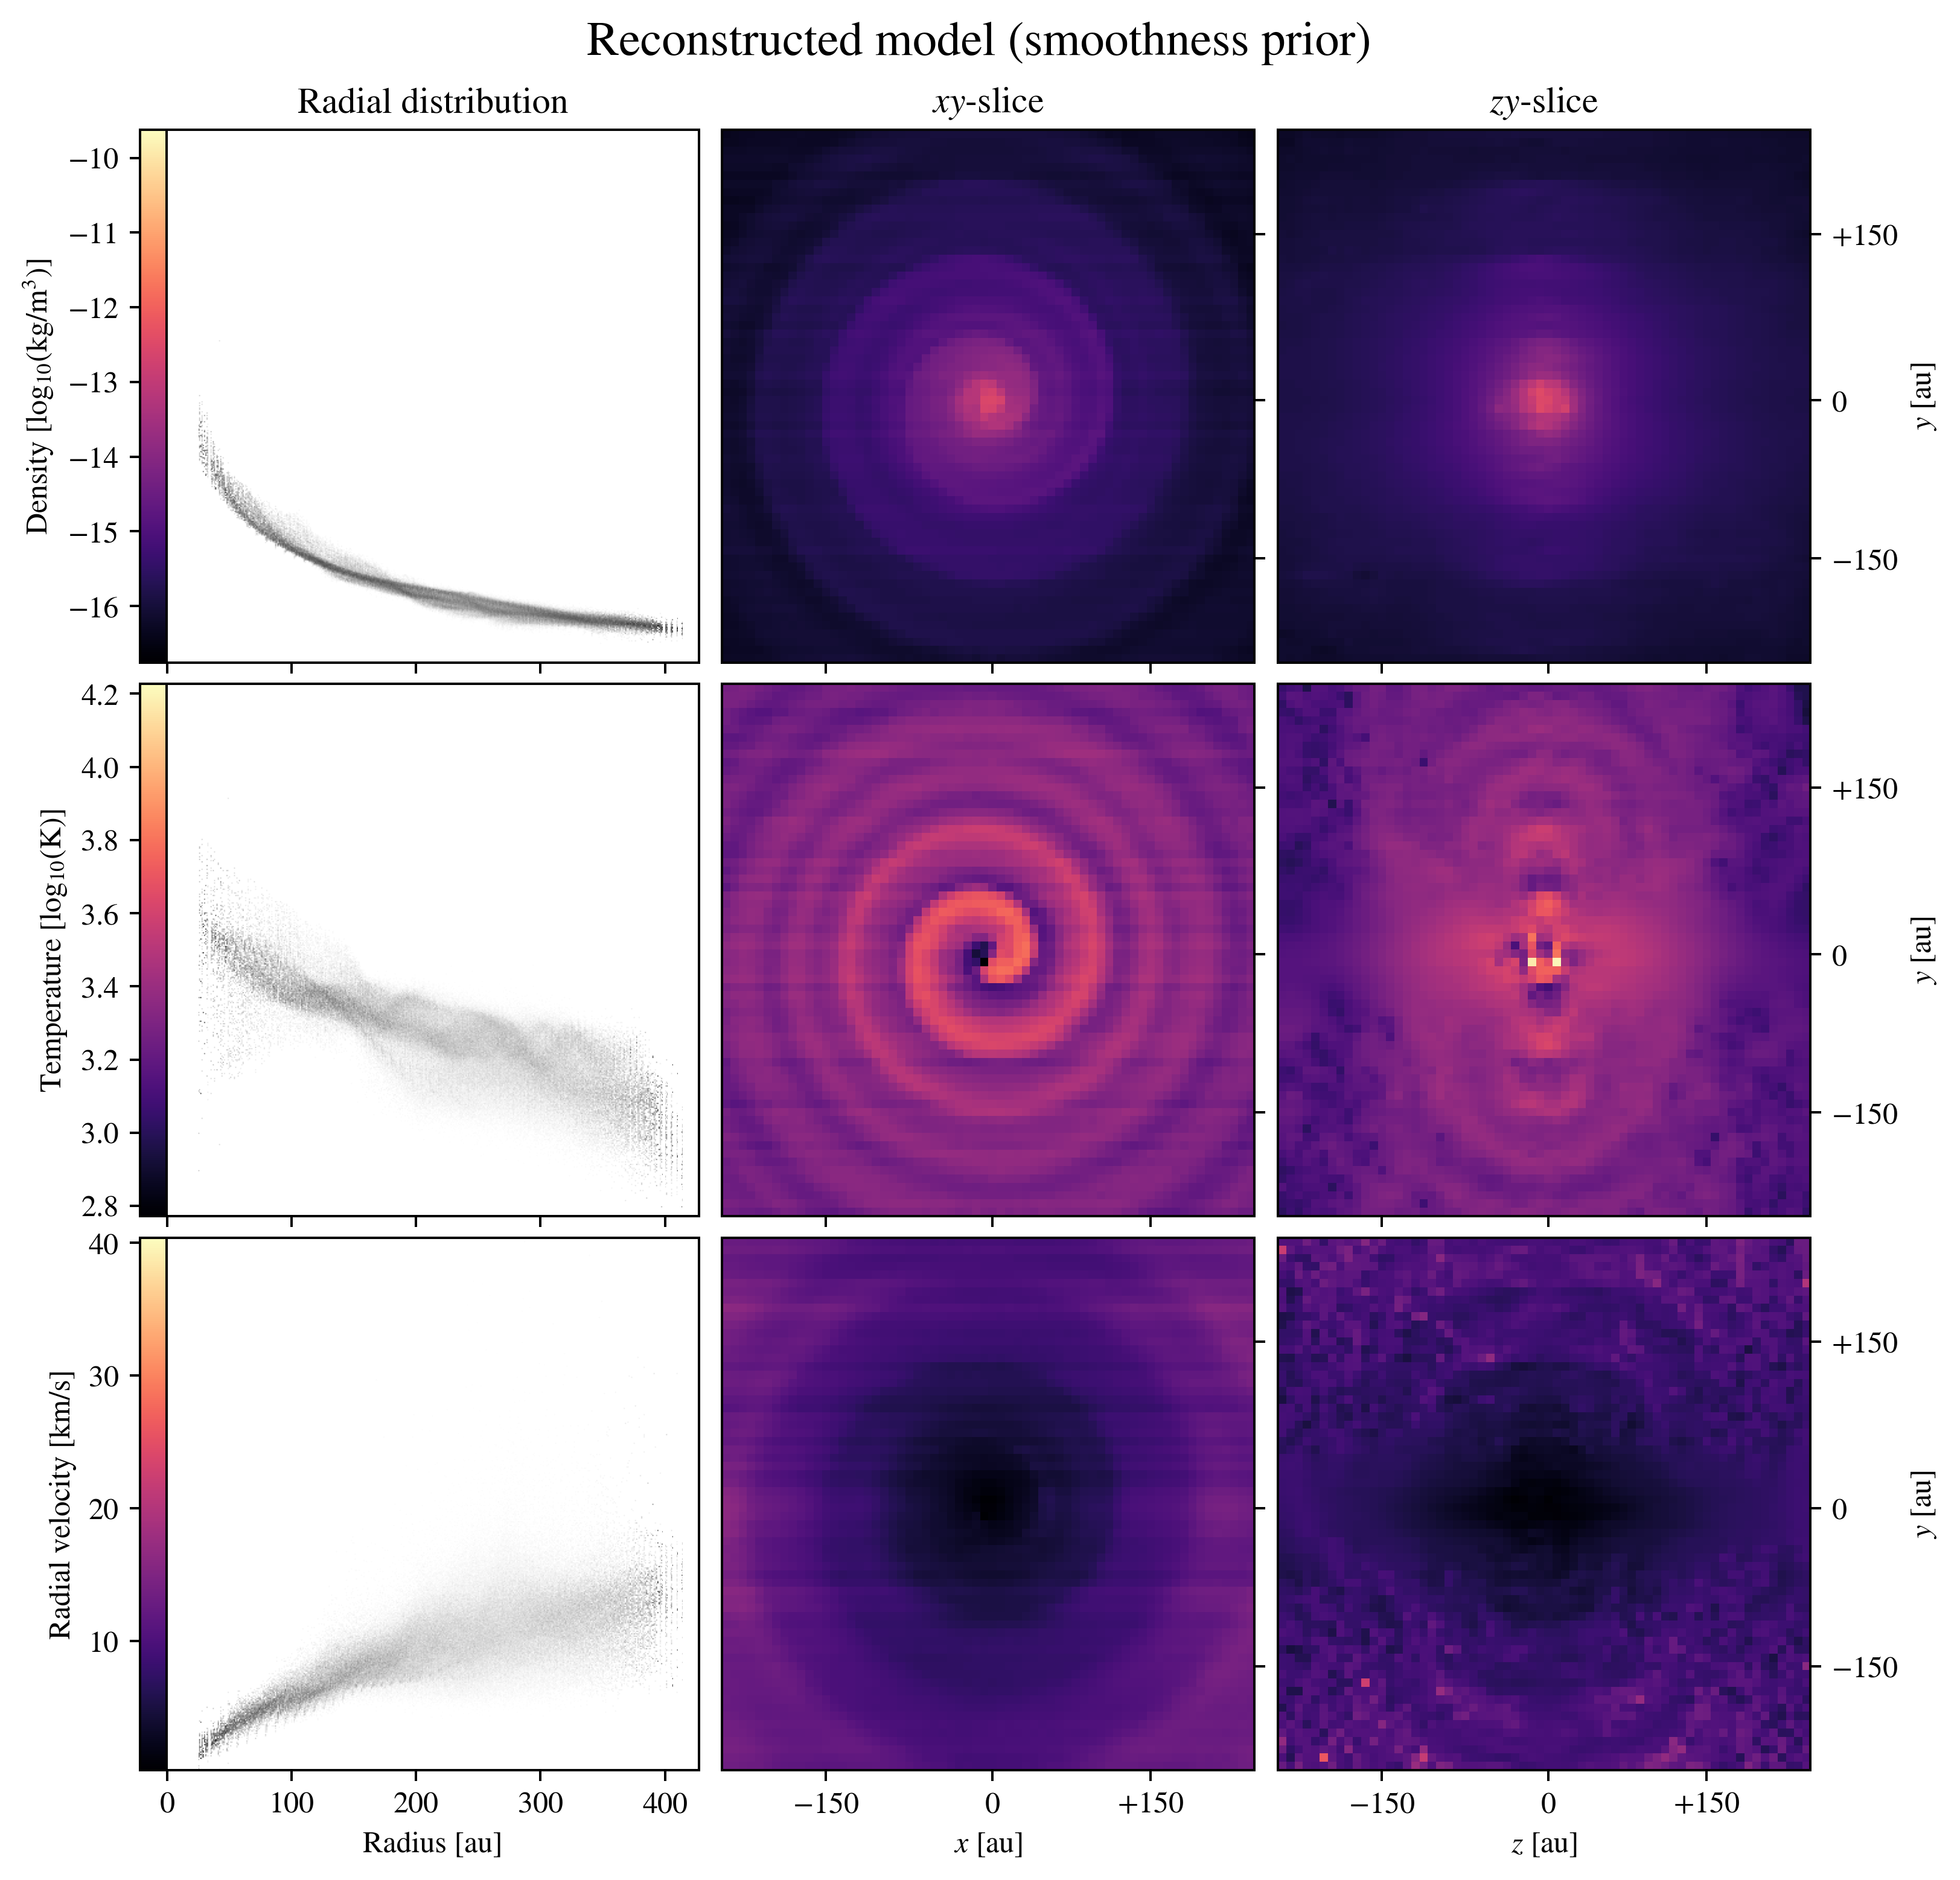

In [25]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

fig.suptitle('Reconstructed model (smoothness prior)', fontsize=16, x=0.527, y=0.93)

cmap = 'magma' #cubehelix'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(rho_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(rho_x_edges, rho_y_edges))[0]
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[0,1].imshow(data[:,  :,128//4].T, vmin=rho_min, vmax=rho_max, cmap=cmap)
pp = axs[0,2].imshow(data[128//4, :, :]  , vmin=rho_min, vmax=rho_max, cmap=cmap)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([51//4, 128//4, 205//4], [])
axs[0,1].set_yticks([51//4, 128//4, 205//4], [])
axs[0,2].set_xticks([51//4, 128//4, 205//4], [])
axs[0,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='Density [log$_{10}$(kg/m$^{3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(tmp_x_edges, tmp_y_edges))[0]
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[1,1].imshow(data[:,  :,128//4].T, vmin=tmp_min, vmax=tmp_max, cmap=cmap)
pp = axs[1,2].imshow(data[128//4, :, :]  , vmin=tmp_min, vmax=tmp_max, cmap=cmap)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([51//4, 128//4, 205//4], [])
axs[1,1].set_yticks([51//4, 128//4, 205//4], [])
axs[1,2].set_xticks([51//4, 128//4, 205//4], [])
axs[1,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()


data = v_r_fit / 1.0e+3
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(v_r_x_edges, v_r_y_edges))[0]
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[2,1].imshow(data[:,  :,128//4].T, vmin=v_r_min, vmax=v_r_max, cmap=cmap)
pp = axs[2,2].imshow(data[128//4, :, :]  , vmin=v_r_min, vmax=v_r_max, cmap=cmap)
# axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,1].set_yticks([51//4, 128//4, 205//4], [])
axs[2,2].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig(f'phantom_{name}.png', dpi=360, bbox_inches='tight')

# Fit no prior
---

In [9]:
name  = 'model_fit_it_no_con_no_diff=600'
model = TensorModel.load(f'{name}.h5')
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +1.668e+01     +2.413e+01     +3.662e+01
  log_temperature            Free          True     -1.484e+00     +7.590e+00     +1.195e+01
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +1.137e+00     +9.060e+00     +1.829e+01
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [10]:
rho_fit = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit = torch.exp(model['log_temperature']).data.numpy()
v_r_fit = torch.exp(model['log_velocity_r' ]).data.numpy()

rs  = model.get_radius(origin='centre')
rs /= (1.0 * units.au).si.value

In [11]:
rho_fit.shape

(64, 64, 64)

In [12]:
256 / 64

4.0

/tmp/ipykernel_499869/2797429833.py:17: RuntimeWarning: invalid value encountered in true_divide
  axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_499869/2797429833.py:38: RuntimeWarning: invalid value encountered in true_divide
  axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_499869/2797429833.py:57: RuntimeWarning: invalid value encountered in true_divide
  axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')


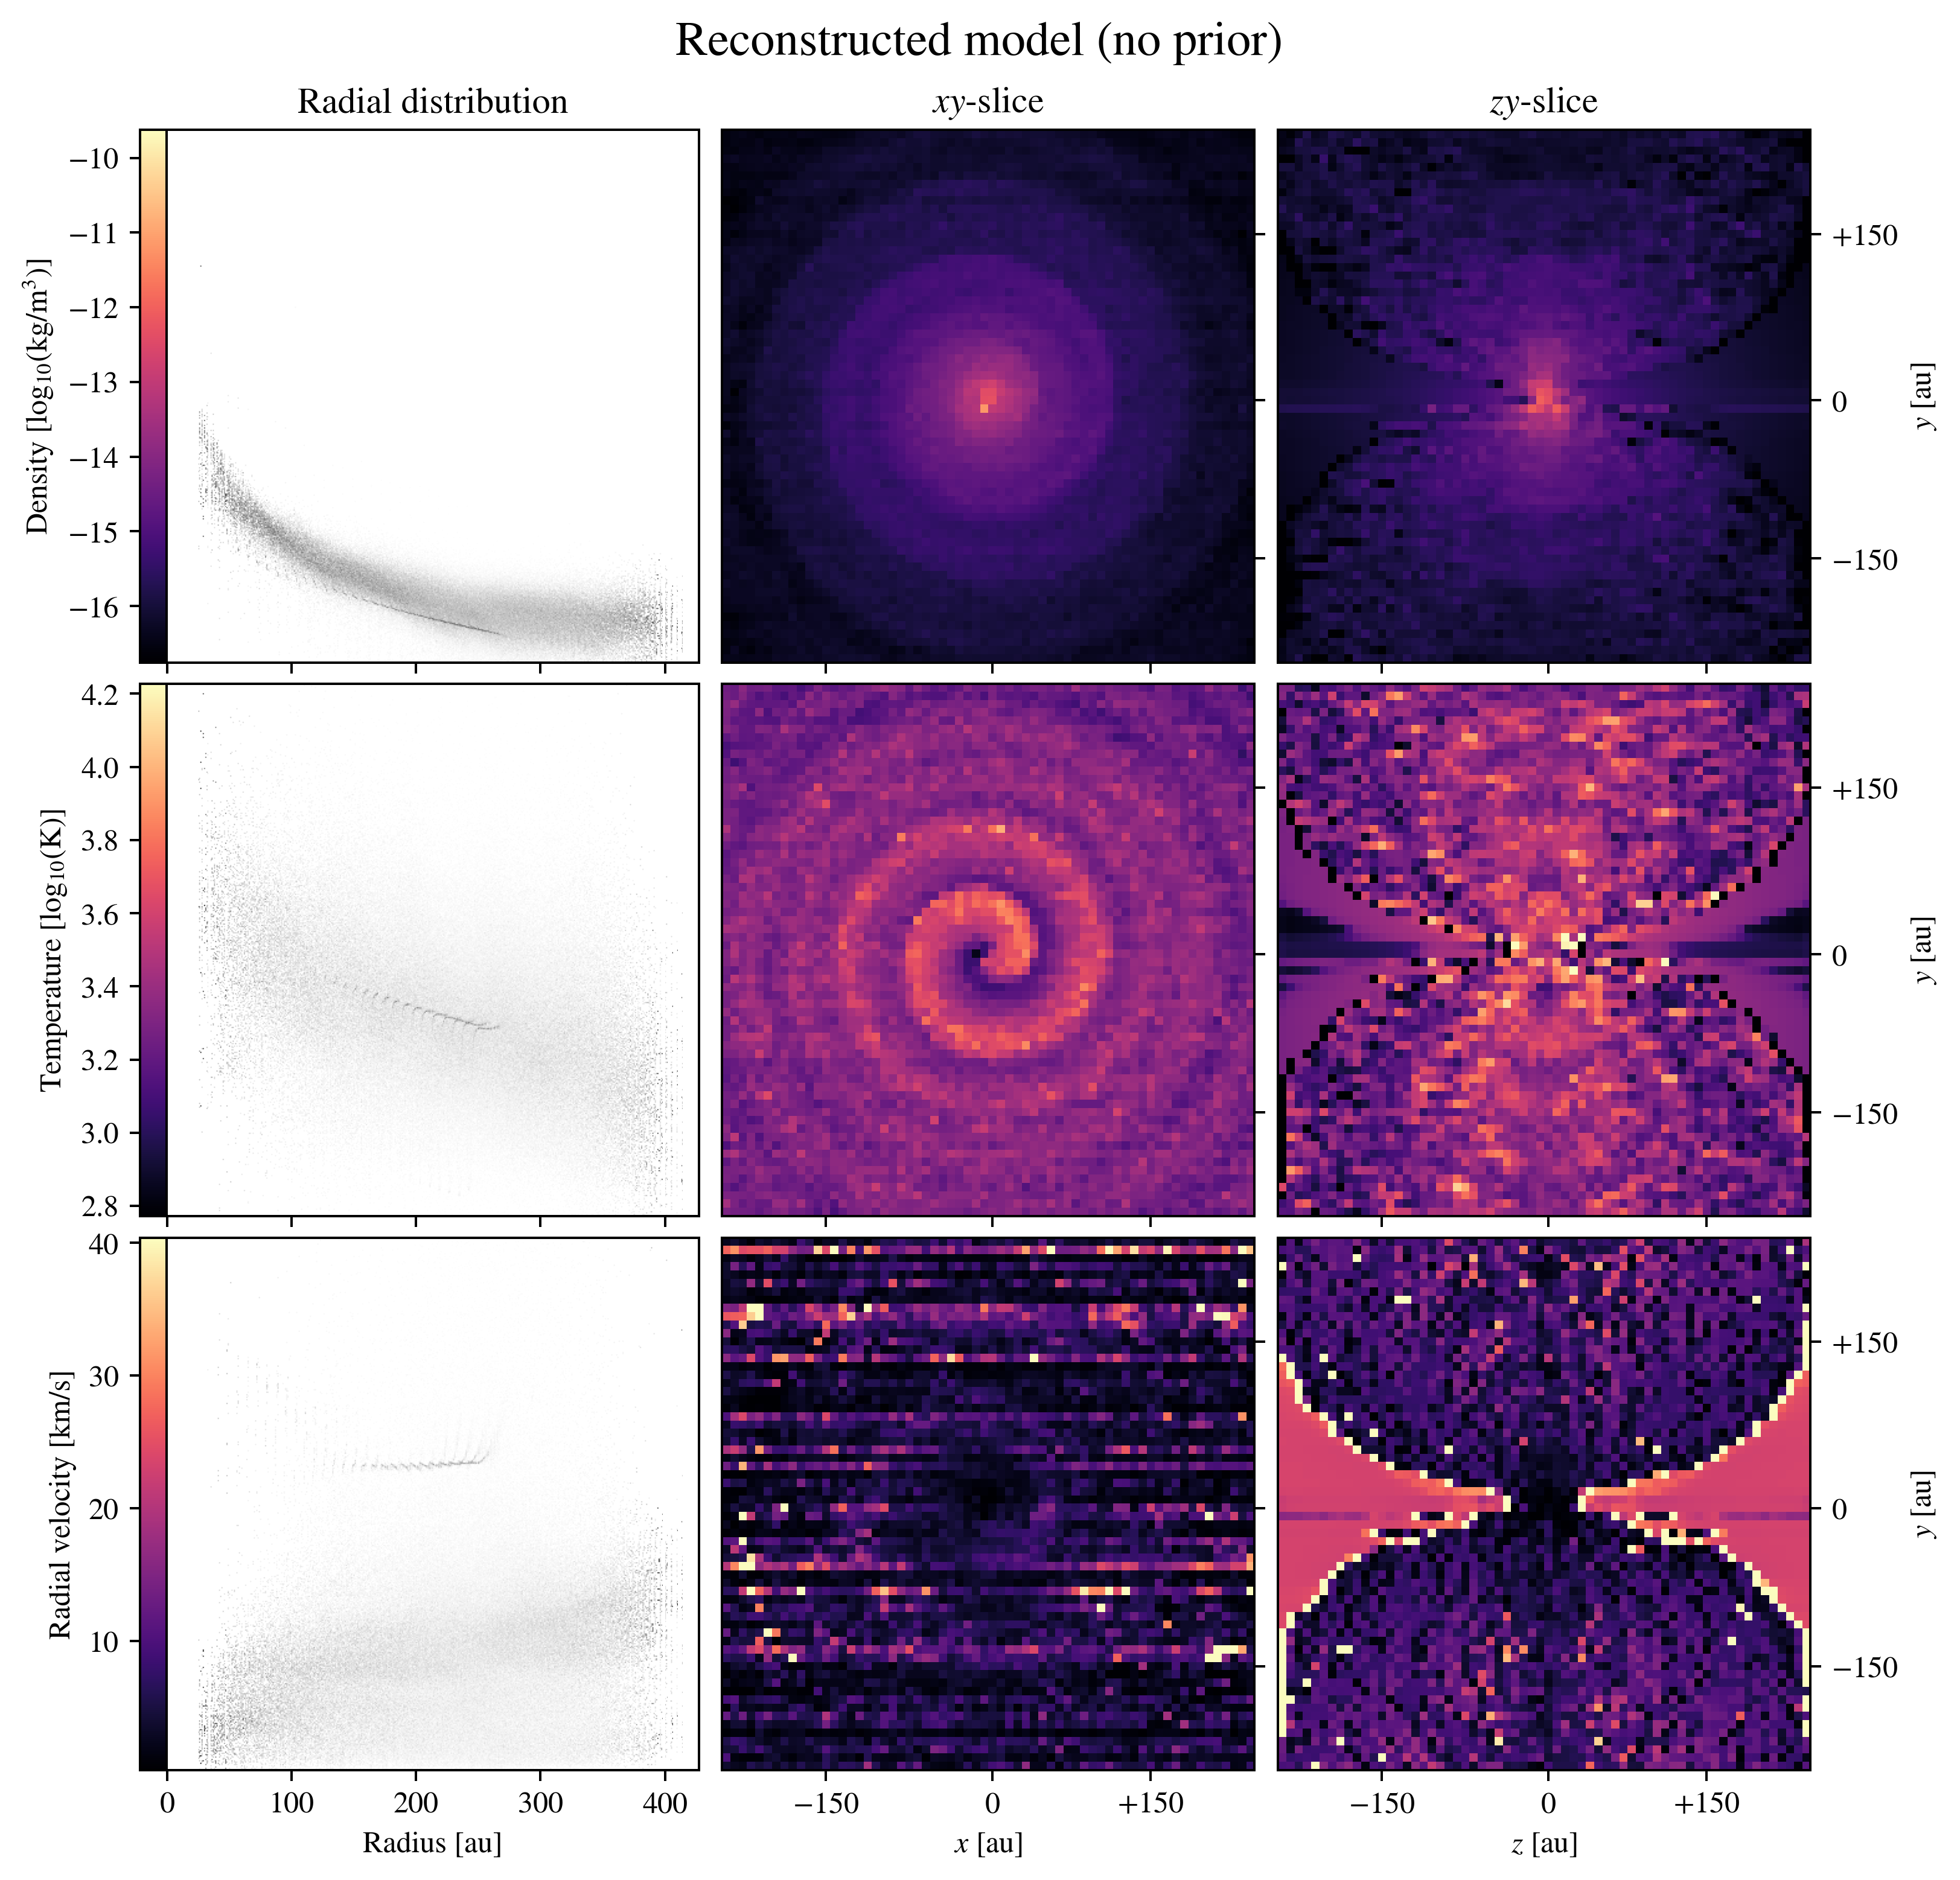

In [13]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

fig.suptitle('Reconstructed model (no prior)', fontsize=16, x=0.527, y=0.93)

cmap = 'magma' #cubehelix'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(rho_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(rho_x_edges, rho_y_edges))[0]
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[0,1].imshow(data[:,  :,128//4].T, vmin=rho_min, vmax=rho_max, cmap=cmap)
pp = axs[0,2].imshow(data[128//4, :, :]  , vmin=rho_min, vmax=rho_max, cmap=cmap)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([51//4, 128//4, 205//4], [])
axs[0,1].set_yticks([51//4, 128//4, 205//4], [])
axs[0,2].set_xticks([51//4, 128//4, 205//4], [])
axs[0,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='Density [log$_{10}$(kg/m$^{3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_fit)
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(tmp_x_edges, tmp_y_edges))[0]
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[1,1].imshow(data[:,  :,128//4].T, vmin=tmp_min, vmax=tmp_max, cmap=cmap)
pp = axs[1,2].imshow(data[128//4, :, :]  , vmin=tmp_min, vmax=tmp_max, cmap=cmap)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([51//4, 128//4, 205//4], [])
axs[1,1].set_yticks([51//4, 128//4, 205//4], [])
axs[1,2].set_xticks([51//4, 128//4, 205//4], [])
axs[1,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()


data = v_r_fit / 1.0e+3
# data_min = data.min()
# data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(v_r_x_edges, v_r_y_edges))[0]
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[2,1].imshow(data[:,  :,128//4].T, vmin=v_r_min, vmax=v_r_max, cmap=cmap)
pp = axs[2,2].imshow(data[128//4, :, :]  , vmin=v_r_min, vmax=v_r_max, cmap=cmap)
# axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,1].set_yticks([51//4, 128//4, 205//4], [])
axs[2,2].set_xticks([51//4, 128//4, 205//4], ['$-150$', '$0$', '$+150$'])
axs[2,2].set_yticks([51//4, 128//4, 205//4], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig(f'phantom_{name}.png', dpi=360, bbox_inches='tight')

# Difference
---

In [9]:
name  = 'model_fit_it=000'
model = TensorModel.load(f'{name}.h5')

rho_fit_0 = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit_0 = torch.exp(model['log_temperature']).data.numpy()
v_r_fit_0 = torch.exp(model['log_velocity_r' ]).data.numpy()

In [10]:
# name  = 'model_fit_it=100'
# model = TensorModel.load(f'{name}.h5')

# rho_fit_1 = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
# tmp_fit_1 = torch.exp(model['log_temperature']).data.numpy()
# v_r_fit_1 = torch.exp(model['log_velocity_r' ]).data.numpy()

In [11]:
# name  = 'model_fit_it=200'
# model = TensorModel.load(f'{name}.h5')

# rho_fit_2 = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
# tmp_fit_2 = torch.exp(model['log_temperature']).data.numpy()
# v_r_fit_2 = torch.exp(model['log_velocity_r' ]).data.numpy()

In [12]:
# name  = 'model_fit_it=300'
# model = TensorModel.load(f'{name}.h5')

# rho_fit_3 = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
# tmp_fit_3 = torch.exp(model['log_temperature']).data.numpy()
# v_r_fit_3 = torch.exp(model['log_velocity_r' ]).data.numpy()

In [13]:
name  = 'model_fit_it=600'
model = TensorModel.load(f'{name}.h5')

rho_fit_6 = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit_6 = torch.exp(model['log_temperature']).data.numpy()
v_r_fit_6 = torch.exp(model['log_velocity_r' ]).data.numpy()

In [14]:
name  = 'model_fit_it_no_con=600'
model = TensorModel.load(f'{name}.h5')

rho_fit_6_nocon = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit_6_nocon = torch.exp(model['log_temperature']).data.numpy()
v_r_fit_6_nocon = torch.exp(model['log_velocity_r' ]).data.numpy()

In [17]:
name  = 'model_fit_it_no_con_no_diff=600'
model = TensorModel.load(f'{name}.h5')

rho_fit_6_nono = torch.exp(model['log_H2'         ]).data.numpy() * 2.02e-3 / constants.N_A.si.value
tmp_fit_6_nono = torch.exp(model['log_temperature']).data.numpy()
v_r_fit_6_nono = torch.exp(model['log_velocity_r' ]).data.numpy()

In [18]:
relative_difference = lambda a, b: np.abs(a-b) / (0.5*(a+b))

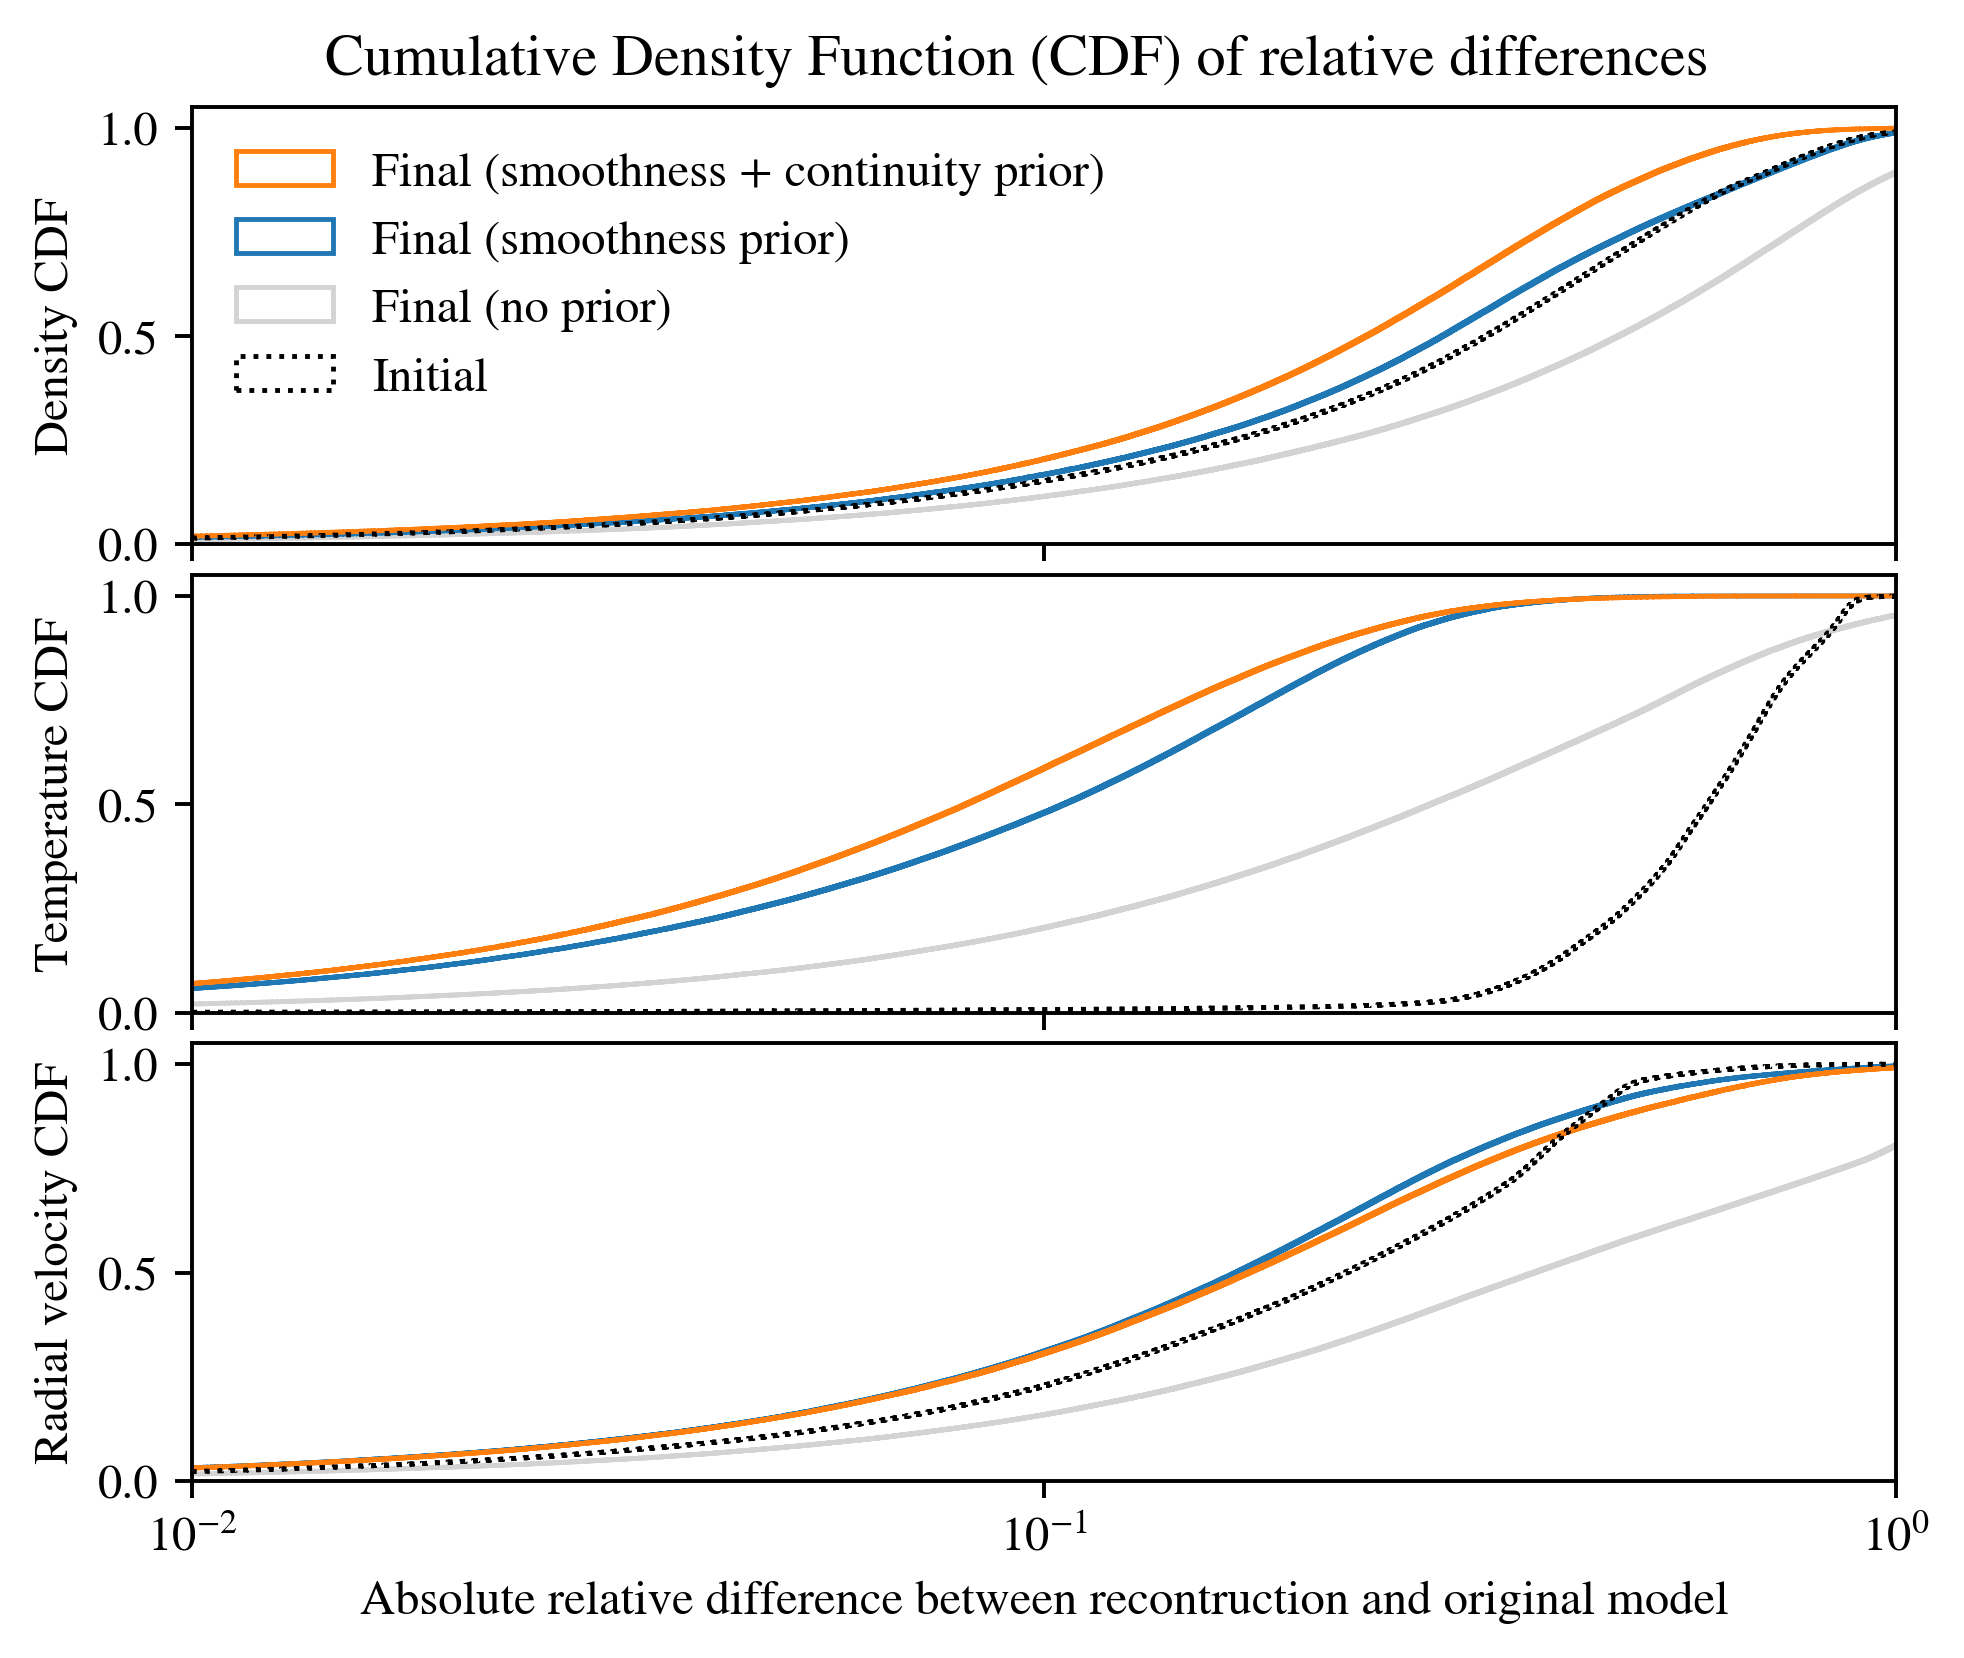

In [90]:
fig, axs = plt.subplots(nrows=3, ncols=1, dpi=350, sharex=True, figsize=(6.28,5.2), gridspec_kw={'width_ratios':[1], 'height_ratios':[1,1,1], 'wspace':0.25, 'hspace':0.07})

# ax = fig.add_subplot(111)

fig.suptitle('Cumulative Density Function (CDF) of relative differences', y=0.92, fontsize=12)

rd_rho_0 = np.log10(relative_difference(rho_fit_0, rho_ref).ravel())
rd_tmp_0 = np.log10(relative_difference(tmp_fit_0, tmp_ref).ravel())
rd_v_r_0 = np.log10(relative_difference(v_r_fit_0, v_r_ref).ravel())

rd_rho_6 = np.log10(relative_difference(rho_fit_6, rho_ref).ravel())
rd_tmp_6 = np.log10(relative_difference(tmp_fit_6, tmp_ref).ravel())
rd_v_r_6 = np.log10(relative_difference(v_r_fit_6, v_r_ref).ravel())

rd_rho_6_nocon = np.log10(relative_difference(rho_fit_6_nocon, rho_ref).ravel())
rd_tmp_6_nocon = np.log10(relative_difference(tmp_fit_6_nocon, tmp_ref).ravel())
rd_v_r_6_nocon = np.log10(relative_difference(v_r_fit_6_nocon, v_r_ref).ravel())

rd_rho_6_nono = np.log10(relative_difference(rho_fit_6_nono, rho_ref).ravel())
rd_tmp_6_nono = np.log10(relative_difference(tmp_fit_6_nono, tmp_ref).ravel())
rd_v_r_6_nono = np.log10(relative_difference(v_r_fit_6_nono, v_r_ref).ravel())

axs[0].hist(rd_rho_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':', label='Initial')
axs[0].hist(rd_rho_6_nono,  bins=10000, histtype='step', density=True, cumulative=True, color='lightgrey',  label='Final (no prior)')
axs[0].hist(rd_rho_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue',   label='Final (smoothness prior)' )
axs[0].hist(rd_rho_6,       bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', label='Final (smoothness + continuity prior)')
axs[0].hist(rd_rho_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(frameon=False, loc='upper left', handles=reversed(handles), labels=reversed(labels))

axs[1].hist(rd_tmp_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':', label='Initial')
axs[1].hist(rd_tmp_6_nono,  bins=10000, histtype='step', density=True, cumulative=True, color='lightgrey',  label='Final (no prior)')
axs[1].hist(rd_tmp_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue',   label='Final (smoothness prior)' )
axs[1].hist(rd_tmp_6,       bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', label='Final (smoothness + continuity prior)')
axs[1].hist(rd_tmp_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':', label='Initial')

axs[2].hist(rd_v_r_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':', label='Initial')
axs[2].hist(rd_v_r_6_nono,  bins=10000, histtype='step', density=True, cumulative=True, color='lightgrey',  label='Final (no prior)')
axs[2].hist(rd_v_r_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue',   label='Final (smoothness prior)' )
axs[2].hist(rd_v_r_6,       bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', label='Final (smoothness + continuity prior)')
axs[2].hist(rd_v_r_0,       bins=10000, histtype='step', density=True, cumulative=True, color='k', linestyle=':', label='Initial')


# ax.hist(rd_rho_6, bins=10000, histtype='step', density=True, cumulative=True, color='k', label='Initial', linestyle=(0, (1, 1.5)))
# ax.hist(rd_rho_6, bins=10000, histtype='step', density=True, cumulative=True, color='k', label='Final (no prior)', alpha=0.21)#, linestyle=(0, (1, .7)))
# ax.hist(rd_rho_6, bins=10000, histtype='step', density=True, cumulative=True, color='k', label='Final (smoothness prior)', alpha=0.47)#, linestyle='dashed')
# ax.hist(rd_rho_6, bins=10000, histtype='step', density=True, cumulative=True, color='k', label='Final (smoothness + continuity prior)')

# ax.hist(rd_rho_0, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue',   alpha=1, linestyle=(0, (1, 1.5)))
# ax.hist(rd_tmp_0, bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', alpha=1, linestyle=(0, (1, 1.5)))
# ax.hist(rd_v_r_0, bins=10000, histtype='step', density=True, cumulative=True, color='tab:green',  alpha=1, linestyle=(0, (1, 1.5)))

# ax.hist(rd_rho_6, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue',   label='Density')
# ax.hist(rd_tmp_6, bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', label='Temperature')
# ax.hist(rd_v_r_6, bins=10000, histtype='step', density=True, cumulative=True, color='tab:green',  label='Radial velocity')


# ax.hist(rd_rho_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue', alpha=0.47)#, linestyle='dashed')
# ax.hist(rd_tmp_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', alpha=0.47)#, linestyle='dashed')
# ax.hist(rd_v_r_6_nocon, bins=10000, histtype='step', density=True, cumulative=True, color='tab:green', alpha=0.47)#, linestyle='dashed')

# ax.hist(rd_rho_6_nono, bins=10000, histtype='step', density=True, cumulative=True, color='tab:blue', alpha=0.21)#, linestyle=(0, (1, .7)))
# ax.hist(rd_tmp_6_nono, bins=10000, histtype='step', density=True, cumulative=True, color='tab:orange', alpha=0.21)#, linestyle=(0, (1, .7)))
# ax.hist(rd_v_r_6_nono, bins=10000, histtype='step', density=True, cumulative=True, color='tab:green', alpha=0.21)#, linestyle=(0, (1, .7)))

axs[0].set_ylabel('Density CDF')
axs[1].set_ylabel('Temperature CDF')
axs[2].set_ylabel('Radial velocity CDF')
axs[2].set_xlabel('Absolute relative difference between recontruction and original model')

axs[2].set_xticks([-3, -2, -1, 0],['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
axs[2].set_xlim((-2, 0))


# handles, labels = ax.get_legend_handles_labels()
# new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
# plt.legend(loc='upper left', frameon=False, handles=new_handles, labels=labels)
# plt.legend(loc='upper left', frameon=False)

plt.savefig(f'phantom_error.pdf', dpi=360, bbox_inches='tight')

In [80]:

handles, labels = axs[0].get_legend_handles_labels()
# new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
# plt.legend(loc='upper left', frameon=False, handles=new_handles, labels=labels)
# plt.legend(loc='upper left', frameon=False)

In [81]:
handles

In [82]:
reversed(handles)